In [2]:
#Import Styles and Dependencies

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
# More Dependencies

import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# Create engine to hawaii.sqlite

engine = create_engine("sqlite:///Data/hawaii.sqlite")

In [6]:
# Reflect an existing database into a new model

Base = automap_base()

# Reflect the tables

Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Inspect the Measurement class to find the column names and types

inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Find the most recent date in the data set.

recent_date = session.query(func.max(Measurement.date)).scalar()
print(recent_date)

2017-08-23


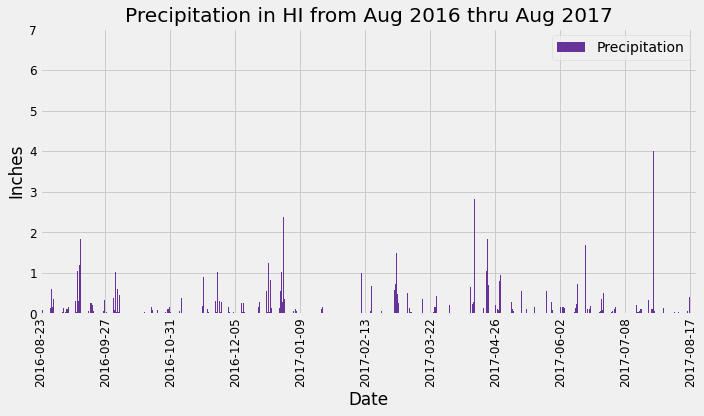

In [37]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

split_date = recent_date.split('-')

query_date = dt.date(int(split_date[0]), int(split_date[1]), int(split_date[2])) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores, ordered by date

rain_year = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date <= recent_date).\
        filter(Measurement.date >= query_date).\
        order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

rain_df = pd.DataFrame(rain_year, columns=['Date', 'Precipitation'])
rain_df.set_index('Date', inplace=True)
rain_fixed = rain_df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data

ax = rain_fixed.plot.bar(color = 'rebeccapurple', figsize = (10,6))
ax.xaxis.set_ticklabels(rain_fixed.index.values[::200])
ax.xaxis.set_ticks(np.arange(0, len(rain_fixed.index), 200))

# Plot aesthetics

plt.title('Precipitation in HI from Aug 2016 thru Aug 2017')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 12)

# Saving plot to output as png

output_image = f'Output/Rain_HI.png'
plt.tight_layout()
plt.savefig(output_image)

plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data

rain_fixed.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Inspect the Station class to find the column names and types

inspector = inspect(engine)
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to calculate the total number stations in the dataset

num_stations = session.query(Station.id).count()
print(num_stations)

9


In [41]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

most_active = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()
print(most_active)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [42]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_info = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                                filter(Measurement.station == most_active[0][0]).all()

# Printing the statistics found for most active station
                                 
print(f"Most Active Station {most_active[0][0]} Statistics")
print(f"Min Temperature = {most_active_info[0][0]}")
print(f"Max Temperature = {most_active_info[0][1]}")
print(f"Avg Temparature = {round(most_active_info[0][2],2)}")

Most Active Station USC00519281 Statistics
Min Temperature = 54.0
Max Temperature = 85.0
Avg Temparature = 71.66


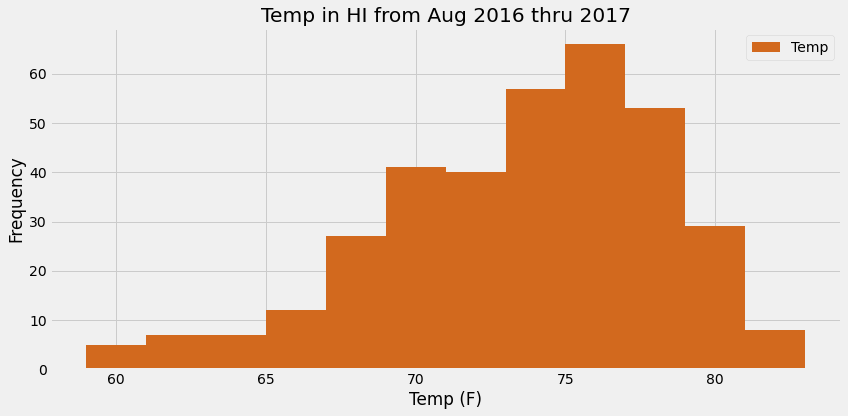

In [28]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_year = session.query(Measurement.tobs).\
        filter(Measurement.date <= recent_date).\
        filter(Measurement.date >= query_date).\
        filter(Measurement.station == most_active[0]).all()

# Save the query results as a Pandas DataFrame

temp_df = pd.DataFrame(temp_year, columns=['Temp'])
temp_fixed = temp_df.dropna()

# Creating a histogram of the temperatures and their frequency

temp_fixed.plot.hist(bins = 12, color = 'chocolate', figsize = (12,6))

# Plot aesthetics

plt.title('Temp in HI from Aug 2016 thru 2017')
plt.xlabel('Temp (F)')
plt.ylabel('Frequency')

# Saving plot to output as png

output_image = f'Output/Temp_HI.png'
plt.tight_layout()
plt.savefig(output_image)

plt.show()

# Close session

In [ ]:
# Close Session

session.close()